In [ ]:
# 01_preprocessing.ipynb

from pathlib import Path
import re
import numpy as np
import pandas as pd

# ------------------------ Path configuration ------------------------ #
# Base folder for this project
BASE_DIR = Path(r"C:\Users\Admin\Desktop\Tai-Seale Lab")

DATA_DIR = BASE_DIR / "data"

# If you later create "raw" and "processed" subfolders, you can change RAW_DIR.
# For now we assume the original CSV is directly under DATA_DIR.
RAW_DIR = DATA_DIR
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV = RAW_DIR / "message_text 2025 06 05_sentiment_analysis_scrambled_with_count(in).csv"

print("Reading raw CSV from:", RAW_CSV)

# ------------------------ Load raw data ------------------------ #
# Use latin1 because UTF-8 raised a UnicodeDecodeError.
df = pd.read_csv(RAW_CSV, encoding="latin1")

# AE = message from patient
COL_AE = "Deidentified text Message text from patient (Extracted) "
# AF = message to patient (provider response)
COL_AF = "Deidentified text Message text to patient (Extracted)"

# Safety check: make sure the columns exist
assert COL_AE in df.columns, f"Column not found: {COL_AE}"
assert COL_AF in df.columns, f"Column not found: {COL_AF}"

# ------------------------ Remove old helper columns if re-running ------------------------ #
# This prevents duplicated columns like AE_raw.1, AE_clean.2, etc.
for col in ["AE_raw", "AF_raw", "AE_clean", "AF_clean"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# ------------------------ Preserve raw text ------------------------ #
# Keep the exact original text in separate columns for reference.
df["AE_raw"] = df[COL_AE]
df["AF_raw"] = df[COL_AF]


# ------------------------ Clean <Redacted> ------------------------ #
def clean_redacted(text):
    """
    Clean a single text cell:
    - Keep NaN as NaN (do not force to empty string).
    - Replace any <Redacted ...> placeholder with a neutral token [NAME].
    - Normalize whitespace.
    """
    if not isinstance(text, str):
        # Return NaN for non-string values (e.g., missing values)
        return np.nan

    # Replace any variant like "<Redacted>", "< redacted >", "<Redacted name>" with [NAME]
    cleaned = re.sub(r"<\s*redacted[^>]*>", "[NAME]", text, flags=re.IGNORECASE)

    # Collapse multiple whitespaces into a single space
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    return cleaned


# Apply cleaning to AE / AF to create "clean" versions
df["AE_clean"] = df["AE_raw"].apply(clean_redacted)
df["AF_clean"] = df["AF_raw"].apply(clean_redacted)

def fix_mojibake_quotes(text):
    """
    Fix mojibake patterns where apostrophes or quotes were corrupted.
    Examples:
      "I?聙?m"      -> "I'm"
      "She?聙?s"    -> "She's"
      "?聙?wanna?聙聺" -> "'wanna'"
    Strategy:
      1) Replace any pattern starting with '?' followed by 1–5 non-alphanumeric
         garbage characters as a simple apostrophe.
      2) Remove remaining non-ASCII junk characters.
    """
    if not isinstance(text, str):
        return text

    # Step 1: collapse patterns like "?聙?", "?聙聺", "?聙隆卤" into a single apostrophe
    # Pattern: '?' + 1–5 non-alphanumeric, non-space characters
    text = re.sub(r"\?[^A-Za-z0-9\s]{1,5}", "'", text)

    # Step 2 (optional but helpful here): remove remaining non-ASCII junk
    # This will strip stray characters like 聺, 隆, 卤 that slipped through.
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # Normalize repeated apostrophes and whitespace
    text = text.replace("''", "'")
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["AE_clean"] = df["AE_clean"].apply(fix_mojibake_quotes)
df["AF_clean"] = df["AF_clean"].apply(fix_mojibake_quotes)
# ------------------------ Save processed data ------------------------ #
CLEAN_CSV = PROCESSED_DIR / "message_text_cleaned.csv"
df.to_csv(CLEAN_CSV, index=False)

print("Preprocessing finished.")
print("Cleaned file saved to:", CLEAN_CSV)

In [ ]:
# 02_vader.ipynb

from pathlib import Path
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# ------------------------ Path configuration ------------------------ #
BASE_DIR = Path(r"C:\Users\Admin\Desktop\Tai-Seale Lab")

DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV = PROCESSED_DIR / "message_text_cleaned.csv"

print("Loading cleaned data from:", CLEAN_CSV)

# ------------------------ Load cleaned data ------------------------ #
# Use latin1 for consistency with preprocessing step
df = pd.read_csv(CLEAN_CSV, encoding="latin1")

# Expected columns from preprocessing
AE_RAW_COL = "AE_raw"
AF_RAW_COL = "AF_raw"
AE_CLEAN_COL = "AE_clean"
AF_CLEAN_COL = "AF_clean"

for col in [AE_RAW_COL, AF_RAW_COL, AE_CLEAN_COL, AF_CLEAN_COL]:
    assert col in df.columns, f"Column not found: {col}"

print("Columns available:", df.columns.tolist())

# ------------------------ Create master sentiment file if not exists ------------------------ #
MASTER_PATH = RESULTS_DIR / "sentiments_master.csv"

if not MASTER_PATH.exists():
    base_df = df[[AE_CLEAN_COL, AF_CLEAN_COL]].copy()
    base_df.to_csv(MASTER_PATH, index=True)
    print("Created new master file:", MASTER_PATH)
else:
    print("Master file already exists:", MASTER_PATH)

# ------------------------ VADER setup ------------------------ #
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

def vader_score(text):
    """
    Compute VADER compound score for a given text.
    - If text is empty or NaN, return 0.0 as a neutral / no-information score.
    """
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    scores = sia.polarity_scores(text)
    return float(scores["compound"])

# ------------------------ Apply VADER to AE / AF ------------------------ #
df["AE_vader"] = df[AE_CLEAN_COL].apply(vader_score)
df["AF_vader"] = df[AF_CLEAN_COL].apply(vader_score)

print("Sample VADER scores:")
print(
    df[[AE_CLEAN_COL, "AE_vader", AF_CLEAN_COL, "AF_vader"]]
    .head(5)
    .to_string(index=False)
)

# ------------------------ Export aligned results ------------------------ #
vader_dir = RESULTS_DIR / "vader"
vader_dir.mkdir(parents=True, exist_ok=True)

# Use RowID if it exists, otherwise fallback to index
if "RowID" in df.columns:
    row_id = df["RowID"]
else:
    row_id = df.index

# AE-only table
ae_out = pd.DataFrame({
    "RowID": row_id,
    "AE_raw": df[AE_RAW_COL],
    "AE_clean": df[AE_CLEAN_COL],
    "AE_vader": df["AE_vader"],
})

# AF-only table
af_out = pd.DataFrame({
    "RowID": row_id,
    "AF_raw": df[AF_RAW_COL],
    "AF_clean": df[AF_CLEAN_COL],
    "AF_vader": df["AF_vader"],
})

# Combined AE + AF table (most convenient)
both_out = pd.DataFrame({
    "RowID": row_id,
    "AE_raw": df[AE_RAW_COL],
    "AE_clean": df[AE_CLEAN_COL],
    "AE_vader": df["AE_vader"],
    "AF_raw": df[AF_RAW_COL],
    "AF_clean": df[AF_CLEAN_COL],
    "AF_vader": df["AF_vader"],
})

ae_path = vader_dir / "AE_vader_results_aligned.csv"
af_path = vader_dir / "AF_vader_results_aligned.csv"
both_path = vader_dir / "vader_results_aligned.csv"

ae_out.to_csv(ae_path, index=False)
af_out.to_csv(af_path, index=False)
both_out.to_csv(both_path, index=False)

print("VADER results saved to:")
print("  ", ae_path)
print("  ", af_path)
print("  ", both_path)


In [ ]:
# ------------------------ Summary statistics (print only) ------------------------ #
# Ensure numeric types
df["AE_vader"] = pd.to_numeric(df["AE_vader"], errors="coerce")
df["AF_vader"] = pd.to_numeric(df["AF_vader"], errors="coerce")

# Compute delta (provider - patient)
df["delta_vader"] = df["AF_vader"] - df["AE_vader"]

# Main summary dictionary
summary = {
    "Patient_mean": df["AE_vader"].mean(),
    "Patient_std": df["AE_vader"].std(),
    "Patient_median": df["AE_vader"].median(),
    "Patient_min": df["AE_vader"].min(),
    "Patient_max": df["AE_vader"].max(),

    "Provider_mean": df["AF_vader"].mean(),
    "Provider_std": df["AF_vader"].std(),
    "Provider_median": df["AF_vader"].median(),
    "Provider_min": df["AF_vader"].min(),
    "Provider_max": df["AF_vader"].max(),

    "Delta_mean": df["delta_vader"].mean(),
    "Delta_std": df["delta_vader"].std(),
    "Delta_median": df["delta_vader"].median(),
}

# Optional positivity ratios
summary["Patient_positive_rate"] = (df["AE_vader"] > 0.05).mean()
summary["Patient_negative_rate"] = (df["AE_vader"] < -0.05).mean()
summary["Patient_neutral_rate"]  = ((df["AE_vader"] >= -0.05) & (df["AE_vader"] <= 0.05)).mean()

summary["Provider_positive_rate"] = (df["AF_vader"] > 0.05).mean()
summary["Provider_negative_rate"] = (df["AF_vader"] < -0.05).mean()
summary["Provider_neutral_rate"]  = ((df["AF_vader"] >= -0.05) & (df["AF_vader"] <= 0.05)).mean()

# Convert to DataFrame for clean printing
summary_df = pd.DataFrame(summary.items(), columns=["Metric", "Value"])

print("\n===== VADER Summary Statistics =====")
print(summary_df.to_string(index=False))
print("====================================\n")


In [3]:
# 03_roberta.ipynb

from pathlib import Path
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ------------------------ Path configuration ------------------------ #
BASE_DIR = Path(r"C:\Users\Admin\Desktop\Tai-Seale Lab")

DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV = PROCESSED_DIR / "message_text_cleaned.csv"

print("Loading cleaned data from:", CLEAN_CSV)

# ------------------------ Load cleaned data ------------------------ #
# Use latin1 to be consistent with preprocessing
df = pd.read_csv(CLEAN_CSV, encoding="latin1")

AE_RAW_COL = "AE_raw"
AF_RAW_COL = "AF_raw"
AE_CLEAN_COL = "AE_clean"
AF_CLEAN_COL = "AF_clean"

for col in [AE_RAW_COL, AF_RAW_COL, AE_CLEAN_COL, AF_CLEAN_COL]:
    assert col in df.columns, f"Column not found: {col}"

print("Columns available:", df.columns.tolist())

# ------------------------ RoBERTa sentiment model setup ------------------------ #
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
print("Loading model:", MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

id2label = model.config.id2label  # e.g. {0: 'negative', 1: 'neutral', 2: 'positive'}


def roberta_sentiment_score(texts, batch_size=32, max_length=128):
    """
    Compute sentiment scores for a list of texts using RoBERTa.

    For each text, we:
      1) Run the model to obtain logits for [negative, neutral, positive].
      2) Apply softmax to convert logits into probabilities.
      3) Define a continuous sentiment score:
            score = P(positive) - P(negative)
         which lies in the range [-1, 1].

    Empty or NaN texts will receive a score of 0.0 (neutral / no information).
    """
    scores = []
    n = len(texts)

    with torch.no_grad():
        for start in range(0, n, batch_size):
            batch_texts = texts[start:start + batch_size]

            # Replace non-string / empty values with empty string
            processed_batch = [
                t if isinstance(t, str) and t.strip() != "" else ""
                for t in batch_texts
            ]

            enc = tokenizer(
                processed_batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            enc = {k: v.to(device) for k, v in enc.items()}

            outputs = model(**enc)
            logits = outputs.logits  # [batch_size, num_labels]
            probs = torch.softmax(logits, dim=-1).cpu().numpy()  # convert to probabilities

            for p in probs:
                # Map indices to labels using id2label to be robust to label ordering
                if id2label:
                    label_prob = {id2label[i].lower(): float(p[i]) for i in range(len(p))}
                    p_neg = label_prob.get("negative", 0.0)
                    p_pos = label_prob.get("positive", 0.0)
                else:
                    # Fallback: assume [neg, neu, pos]
                    p_neg = float(p[0])
                    p_pos = float(p[2])

                score = p_pos - p_neg  # continuous sentiment polarity in [-1, 1]
                scores.append(score)

    return scores


# ------------------------ Apply RoBERTa to AE / AF ------------------------ #
print("Computing RoBERTa sentiment for AE_clean...")
ae_texts = df[AE_CLEAN_COL].tolist()
df["AE_roberta"] = roberta_sentiment_score(ae_texts, batch_size=32, max_length=128)

print("Computing RoBERTa sentiment for AF_clean...")
af_texts = df[AF_CLEAN_COL].tolist()
df["AF_roberta"] = roberta_sentiment_score(af_texts, batch_size=32, max_length=128)

print("Sample RoBERTa scores:")
print(
    df[[AE_CLEAN_COL, "AE_roberta", AF_CLEAN_COL, "AF_roberta"]]
    .head(5)
    .to_string(index=False)
)

# ------------------------ Export aligned results ------------------------ #
roberta_dir = RESULTS_DIR / "roberta"
roberta_dir.mkdir(parents=True, exist_ok=True)

# Use RowID if it exists, otherwise use index
if "RowID" in df.columns:
    row_id = df["RowID"]
else:
    row_id = df.index

# AE-only table
ae_out = pd.DataFrame({
    "RowID": row_id,
    "AE_raw": df[AE_RAW_COL],
    "AE_clean": df[AE_CLEAN_COL],
    "AE_roberta": df["AE_roberta"],
})

# AF-only table
af_out = pd.DataFrame({
    "RowID": row_id,
    "AF_raw": df[AF_RAW_COL],
    "AF_clean": df[AF_CLEAN_COL],
    "AF_roberta": df["AF_roberta"],
})

# Combined AE + AF table (similar style to VADER)
both_out = pd.DataFrame({
    "RowID": row_id,
    "AE_raw": df[AE_RAW_COL],
    "AE_clean": df[AE_CLEAN_COL],
    "AE_roberta": df["AE_roberta"],
    "AF_raw": df[AF_RAW_COL],
    "AF_clean": df[AF_CLEAN_COL],
    "AF_roberta": df["AF_roberta"],
})

ae_path = roberta_dir / "AE_roberta_results_aligned.csv"
af_path = roberta_dir / "AF_roberta_results_aligned.csv"
both_path = roberta_dir / "roberta_results_aligned.csv"

ae_out.to_csv(ae_path, index=False)
af_out.to_csv(af_path, index=False)
both_out.to_csv(both_path, index=False)

print("RoBERTa results saved to:")
print("  ", ae_path)
print("  ", af_path)
print("  ", both_path)


C:\Users\Admin\anaconda3\envs\Sentiment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading cleaned data from: C:\Users\Admin\Desktop\Tai-Seale Lab\data\processed\message_text_cleaned.csv
Columns available: ['RowID', 'Unnamed: 0.1', 'Unnamed: 0', 'Provider ID', 'Staff message ID from patient', 'Scrambled Identifier', 'Time message sent by patient', 'Day_of_the_week from patient', 'PAT_ID', 'Patient age at time of msg from patient', 'Patient race', 'Patient sex', 'Message text from patient', 'Message text from patient (Extracted)', 'Message text from patient (Extracted) (# Words)', 'Message text from patient (Extracted) (# Char)', 'Message ID to patient', 'Message to patient sent by', 'PROVIDER_TYPE', 'PRIMARY_SPECIALTY', 'WAS_ART_USED_YN', 'BEFORE_AFTER_FIRST_ART_USE', 'Message text to patient', 'Message text to patient (Extracted)', 'Message text to patient (Extracted) (# Words)', 'Message text to patient (Extracted) (# Char)', 'sentiment of message from Patient (Extracted)', 'sentiment of message to Patient (Extracted)', 'Message text from patient (Extracted) person

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing RoBERTa sentiment for AE_clean...


KeyboardInterrupt: 

In [13]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Admin\Desktop\Tai-Seale Lab\results\roberta\roberta_results_aligned.csv")

df.columns


Index(['RowID', 'AE_raw', 'AE_clean', 'AE_roberta', 'AF_raw', 'AF_clean',
       'AF_roberta', 'WAS_ART_USED_YN'],
      dtype='object')

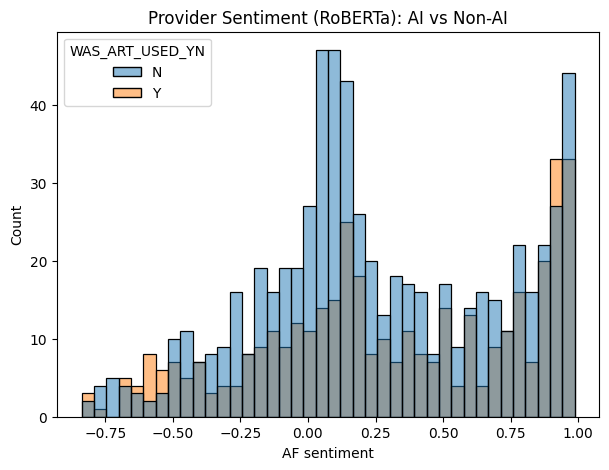

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.histplot(
    data=df,
    x="AF_roberta",
    hue="WAS_ART_USED_YN",
    bins=40,
    alpha=0.5
)
plt.title("Provider Sentiment (RoBERTa): AI vs Non-AI")
plt.xlabel("AF sentiment")
plt.show()



In [15]:
print(df["WAS_ART_USED_YN"].value_counts(dropna=False))


WAS_ART_USED_YN
N                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [15]:

df.groupby("WAS_ART_USED_YN")["AF_roberta"].mean()


WAS_ART_USED_YN
N    0.256113
Y    0.306694
Name: AF_roberta, dtype: float64